In [26]:
cd "/home/enesk/repos/spatial-prediction"

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


OSError: [Errno 28] No space left on device

In [ ]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
from data_set import Dataset
from predictor import Predictor, models
from predictor_utils import PiecewiseSchedule, OptimizerSpec
from utils import get_session, plot_grid, plot_confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import reverb
import pandas as pd
from datetime import datetime
import random
from matplotlib import rc
import matplotlib
from active_sensing_environment import ExplorationEnvironment
from rl_env import RLEnv
import custom_py_driver
import json


import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.trajectories import TimeStep
from tf_agents.policies import policy_saver

2023-06-13 11:41:10.717207: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
print(os.environ['LD_LIBRARY_PATH'])
print(os.environ['XLA_FLAGS'])


/home/enesk/miniconda3/envs/triad4/lib/:/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorrt_libs/
--xla_gpu_cuda_data_dir=/usr/lib/cuda


In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1,' # We don't need a GPU to test the model
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-06-13 11:41:12.473326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:12.493210: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:12.493422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [ ]:
class TemperatureSchedule:
    def __init__(self):
        self.temp = 0.0
    def get_temp(self,):
        return self.temp

In [ ]:
# Training parameters
all_params = {
"num_iterations" :  2000000, # @param {type:"integer"}
"n_step_update" :  5,
"initial_collect_steps" :  100000,  # 30000 @param {type:"integer"}
"collect_steps_per_iteration" :    1,# @param {type:"integer"}
"replay_buffer_max_length" :  4000000,  # @param {type:"integer"}
"batch_size" :  64, # @param {type:"integer"}
"learning_rate" :  1e-4,  # @param {type:"number"}
"log_interval" :  200,  # @param {type:"integer"}
"gamma" :  0.99,
"boltzmann_temperature" :  None, # temp_schedule.get_temp
"fc_layer_params" :  (512, 20),
"epsilon" :  0.1,
"model_restore_path" : None, 
#"conv_layer_params" : [(32,4,4), (64,4,4), (128,2,2)],
"conv_layer_params" : [(64,4,2), (128,4,2), (256,2,2)],
"target_update_tau" :  1,
"target_update_period" : 1000,
"num_eval_episodes" :  300,  # @param {type:"integer"}
"eval_interval" :  50000 , # @param {type:"integer"}
"single_env" :   False,
"use_sd" :  True,
"clairvoyante" :  False,
"num_atoms" : 70,  # @param {type:"integer"}
"use_categorical_dqn" : True,
"min_q_value" : 0,  # @param {type:"integer"}
"max_q_value" : 40, # @param {type:"integer"}
"use_imitation_learning" : False,
"use_pretrain_imitation_learning" : False,
"new_reward_function" : 2,
"step_size" : 4,
"random_init" : 0,
"n_agents" : 2,
"pred_session_name" : 'rand_walk_interpol_2_uav',
}

for key,val in all_params.items():
    exec(key + '=val')

In [ ]:
# Setup environment 
env = RLEnv(model_path=pred_session_name, single_env = single_env, use_sd=use_sd, 
                clairvoyante = clairvoyante, use_imitation_learning=use_imitation_learning,
                    step_size = step_size, new_reward_function = new_reward_function, random_init=random_init,
                        n_uavs = n_agents)



There are 660 training grids.
There are 327 testing grids.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Unet Layers Shapes:
(None, 96, 96, 2)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:loc

2023-06-13 11:41:16.262240: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:16.262475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:16.262828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 128]
[None, 24, 24, 64]
[None, 48, 48, 32]
[None, 96, 96, 16]
(None, 96, 96, 1)
Unet Layers Shapes:
(None, 96, 96, 2)
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12, 128]), TensorShape([None, 6, 6, 128]))
(None, 4608)
(None, 6, 6, 128) reshape_layer_output_shape
[None, 12, 12, 128]
[None, 24, 24, 64]
(None, 96, 96, 1)
INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-06-13 11:41:20.068337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:20.068543: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-13 11:41:20.068636: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-13 11:41:20.068879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:20.069057: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-13 11:41:20.665312: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:20.665522: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-13 11:41:20.665611: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-13 11:41:20.665805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:20.665985: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-06-13 11:41:23.346999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:23.347186: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-13 11:41:23.347266: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-13 11:41:23.347415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:23.347585: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-13 11:41:23.685919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:23.686135: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-13 11:41:23.686226: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-13 11:41:23.686433: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 11:41:23.686731: I tensorflow/compiler/xla/stream_executor/

BoundedArraySpec(shape=(24, 24, 4), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)


In [ ]:
# Storage folder
rl_session_name = datetime.now().strftime("%Y-%m-%d--%H:%M:%S")
#rl_session_name = '2023-05-13--21:30:16'
base_dir = "/home/enesk/repos/spatial-prediction/models/RL"
train_log_dir = base_dir +'/' + rl_session_name
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_summary_writer.set_as_default()
rl_session_name

'2023-06-13--11:41:24'

In [ ]:
# Store config
config_to_store = json.dumps(all_params)
with open(train_log_dir+'/config.json', 'w') as f:
    json.dump(config_to_store, f)

In [ ]:
# Convert to TF environment
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [ ]:

def main():
    env.ee.policy = "random"
    env.ee.action_space.repeat_probability = 0.9
    all_rewards = []
    final_errors = []
    
    for _ in range(1):
        time_steps = train_py_env.reset()
        reward_in_episode = 0
        while not time_steps[0].is_last():
            time_steps = train_py_env.step(action=[1 for _ in time_steps])
            reward_in_episode += time_steps[0].reward
        all_rewards.append(reward_in_episode)
        final_errors.append(env.current_error)
    print("Reward per epsisode", np.mean(all_rewards))
    print("Average error", np.mean(final_errors))
    env.ee.policy = "rl"

%lprun -u 1e-3 -f train_py_env.ee.predict_ss main()


2023-06-13 11:41:25.275388: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2023-06-13 11:41:25.275704: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2023-06-13 11:41:30.361473: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1330] [TF-TRT] Sparse compute capability: enabled.


Reward per epsisode 22.782262802124023
Average error 17.21773740861268


Timer unit: 0.001 s

Total time: 102.22 s
File: /home/enesk/repos/spatial-prediction/active_sensing_environment.py
Function: predict_ss at line 498

Line #      Hits         Time  Per Hit   % Time  Line Contents
   498                                           	def predict_ss(self, user_idx =0, no_full_covariance = False):
   499        52          0.3      0.0      0.0  		city_ob = self.building_grid
   500        52          0.3      0.0      0.0  		pwr_ob = self.ss_grids[user_idx]
   501        52          0.4      0.0      0.0  		indoor = self.building_grid > self.flying_altitude
   502                                           
   503                                           		# Get measured coords
   504        52          9.5      0.2      0.0  		measured_coords = self.get_measured_coords()
   505                                           
   506                                           		# UAV location grid for all UAVs
   507        52          0.4      0.0      0.0  		uav_l

In [ ]:
# Q-network 
if use_categorical_dqn:
    q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)
else:
    print("Using standard DQN")
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)   


In [ ]:
# DQN Agent
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0, dtype=tf.int64)

if use_categorical_dqn:
    agent = categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        categorical_q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        min_q_value=min_q_value,
        debug_summaries=True,
        max_q_value=max_q_value,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)
else:
    print("Using standard DQN agent")
    agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        debug_summaries=True,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

agent.initialize()

2023-06-13 11:43:07.802870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-06-13 11:43:08.480979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [ ]:
# # Define eval function
# def compute_avg_return(environment, py_environment, policy, num_episodes=10):

#   total_return = 0.0
#   episode_errors = []

#   for i in range(num_episodes):

#     time_step = environment.reset()
#     episode_return = 0.0
    

#     while not time_step.is_last():
#       action_step = policy.action(time_step)
#       time_step = environment.step(action_step.action)
#       episode_return += time_step.reward
#     total_return += episode_return
#     episode_errors.append(py_environment.current_error)

#   avg_return = total_return / num_episodes
#   return avg_return.numpy()[0], np.mean(episode_errors), episode_errors

# # New eval function
# # Define eval function
def compute_avg_return(environment, policy, n_agents, num_episodes, batched = True):

  total_return = 0.0
  episode_errors = []

  for i in range(num_episodes):
    # Note that there will be multiple timestep objects for multiple n_agents
    time_steps = environment.reset()
    episode_return = 0.0
    

    while not time_steps[0].is_last():
      action_steps = []
      for agent_idx in range(n_agents):
        # Create a timestep with TF values
        

        if batched:
          discount = tf.constant([time_steps[agent_idx].discount])
          observation = tf.constant([time_steps[agent_idx].observation])
          reward = tf.constant([time_steps[agent_idx].reward])
          step_type = tf.constant([time_steps[agent_idx].step_type])
        else:
          observation = tf.constant(time_steps[agent_idx].observation)
          discount = tf.constant(time_steps[agent_idx].discount)
          reward = tf.constant(time_steps[agent_idx].reward)
          step_type = tf.constant(time_steps[agent_idx].step_type)
        tf_ts = TimeStep( step_type, reward, discount, observation)

        # Get action
        action_step = policy.action(tf_ts)
        action_steps.append(action_step)

      # Step the environment
      time_steps = environment.step([action_step.action for action_step in action_steps])
      
      # Get reward
      episode_return += time_steps[0].reward
      
    total_return += episode_return
    episode_errors.append(environment.current_error)

  avg_return = total_return / num_episodes
  return avg_return, np.mean(episode_errors), episode_errors

In [ ]:
# Eval random policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

rand_reward, rand_pred_error, errors = compute_avg_return(eval_py_env, random_policy, n_agents, num_episodes=1, batched = False)

print((rand_reward, rand_pred_error))


(15.748576164245605, 24.251423838897086)


In [ ]:
# Experience storage
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=n_step_update+1,
    local_server=reverb_server)

rb_observers = []
for _ in range(n_agents):
    rb_observer_i = reverb_utils.ReverbAddTrajectoryObserver(
        replay_buffer.py_client,
        table_name,     
        sequence_length=n_step_update+1)
    rb_observers.append(rb_observer_i)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpfinmita7.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmpfinmita7
[reverb/cc/platform/default/server.cc:71] Started replay server on port 44253


In [ ]:
custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    rb_observers,
    n_agents=n_agents,
    use_imitation_learning = use_pretrain_imitation_learning,
    max_steps=initial_collect_steps).run(train_py_env.reset())

Traversed 9999 steps
Traversed 19999 steps
Traversed 29999 steps
Traversed 39999 steps
Traversed 49999 steps
Traversed 59999 steps
Traversed 69999 steps
Traversed 79999 steps
Traversed 89999 steps
Traversed 99999 steps


([TimeStep(
  {'discount': array(1., dtype=float32),
   'observation': array([[[0.55905676, 0.15455413, 0.        , 0.        ],
          [0.58612674, 0.20711017, 0.        , 0.        ],
          [0.5581977 , 0.21472152, 0.        , 0.        ],
          ...,
          [0.6746772 , 0.16925083, 0.        , 0.        ],
          [0.6223126 , 0.18232435, 0.        , 0.        ],
          [0.34666538, 0.22001816, 0.        , 0.        ]],
  
         [[0.2607943 , 0.16958177, 0.        , 0.        ],
          [0.24133222, 0.16636033, 0.        , 0.        ],
          [0.3651545 , 0.20027025, 0.        , 0.        ],
          ...,
          [0.62935156, 0.16339761, 0.        , 0.        ],
          [0.        , 0.17835912, 0.        , 0.        ],
          [0.        , 0.20324166, 0.        , 0.        ]],
  
         [[0.2415464 , 0.13817601, 0.        , 0.        ],
          [0.22365123, 0.17843716, 0.        , 0.        ],
          [0.32724923, 0.17176129, 0.        , 0.    

In [ ]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=20,
    sample_batch_size=batch_size,
    num_steps=n_step_update+1).prefetch(20)

iterator = iter(dataset)

In [ ]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, avg_error, errors = compute_avg_return(eval_py_env, agent.policy, n_agents, 2)
returns, pred_errors = [avg_return], [avg_error]
returns_collect, pred_errors_collect = [], []

# Reset the environment.
time_step = train_py_env.reset()





In [ ]:
# Create a driver to collect experience.
collect_driver = custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    rb_observers,
    n_agents=n_agents,
    use_imitation_learning=use_imitation_learning,
    max_steps=collect_steps_per_iteration)

In [ ]:
if model_restore_path != None:
    checkpoint_dir = os.path.join(model_restore_path, 'checkpoint')
    train_checkpointer = common.Checkpointer(
        ckpt_dir=checkpoint_dir,
        max_to_keep=1,
        agent=agent,
        policy=agent.policy,
    )
    train_checkpointer.initialize_or_restore()

checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [ ]:
best_reward = np.inf
losses = []
collect_rewards = []

In [ ]:
def main():
  if (use_pretrain_imitation_learning) != False:
    # Dataset generates trajectories with shape [Bx2x...]
    pretrain_dataset = replay_buffer.as_dataset(
        num_parallel_calls=20,
        sample_batch_size=batch_size,
        num_steps=n_step_update+1).prefetch(20)

    pretrain_iterator = iter(pretrain_dataset)

    for i in range(initial_collect_steps):
      # Sample a batch of data from the buffer and update the agent's network.
      step = agent.train_step_counter.numpy()
      experience, unused_info = next(pretrain_iterator)
      loss_info = agent.train(experience)
      train_loss = loss_info.loss
      losses.append(train_loss)
      rew = np.mean((experience.reward))
      collect_rewards.append(rew)
      if step % 1000 == 0:
        print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, rew*env.episode_length))
        with tf.name_scope("Training/"):
          tf.compat.v2.summary.scalar(name="Reward", data=rew*env.episode_length, step=step)
          tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
main()

In [ ]:
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

In [27]:
for _ in range(1000000000):
  step = agent.train_step_counter.numpy()

  # Calculate betta for dagger
  if use_imitation_learning != False:
    start_beta = 0.999
    step_range = 4E6
    end_beta = 0.0
    beta = start_beta - (start_beta-end_beta) * step / step_range
    collect_driver._dagger_beta = beta

  

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  loss_info = agent.train(experience)
  train_loss = loss_info.loss
  losses.append(train_loss)
  rew = np.mean((experience.reward))
  collect_rewards.append(time_step[0].reward)

  

  if step % 1000 == 0:
    
    print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, np.mean(collect_rewards)*env.episode_length))
    with tf.name_scope("Training/"):
      tf.compat.v2.summary.scalar(name="Reward", data=np.mean(collect_rewards)*env.episode_length, step=step)
      tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
    collect_rewards = []

  if step % eval_interval == 0:
    avg_return, avg_error, errors = compute_avg_return(eval_py_env, agent.policy, n_agents,num_eval_episodes)
    #avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}, Average Error = {2}, Median Error = {3}'.format(step, avg_return, avg_error, np.median(errors)))
    returns.append(avg_return)
    pred_errors.append(avg_error)
    with tf.name_scope("Testing/"):
      tf.compat.v2.summary.scalar(name="Reward", data=avg_return, step=step)
      tf.compat.v2.summary.scalar(name="Error", data=avg_error, step=step)
      tf.compat.v2.summary.scalar(name="Median Error", data=np.median(errors), step=step)

    if best_reward > avg_error:
      print("Saving model")
      best_reward = avg_error
      train_checkpointer.save(step)
      tf_policy_saver.save(train_log_dir)
      avg_return, avg_error, errors = compute_avg_return(eval_py_env, agent.policy,  n_agents,num_eval_episodes)
      #avg_return_collect, avg_error_collect, errors_collect = compute_avg_return(eval_py_env, agent.collect_policy,  n_agents,num_eval_episodes)
      print('step = {0}: Average Return = {1}, Average Error = {2}, Median Error = {3}'.format(step, avg_return, avg_error, np.median(errors)))
      #print('step = {0}: Average Return 3 = {1}, Average Error 3 = {2}'.format(step, avg_return_collect, avg_error_collect))

step = 579000: loss = 3.2819888591766357,  rew = 23.56972247362137
step = 580000: loss = 3.3098268508911133,  rew = 22.95239120721817
step = 581000: loss = 3.246108055114746,  rew = 24.043090641498566
step = 582000: loss = 3.284740447998047,  rew = 24.208231270313263
step = 583000: loss = 3.2978334426879883,  rew = 25.88021755218506
step = 584000: loss = 3.3037469387054443,  rew = 24.028000235557556
step = 585000: loss = 3.2906436920166016,  rew = 25.38527548313141
step = 586000: loss = 3.2496566772460938,  rew = 23.849494755268097
step = 587000: loss = 3.3010730743408203,  rew = 24.347969889640808
step = 588000: loss = 3.2893340587615967,  rew = 26.193708181381226
step = 589000: loss = 3.2727928161621094,  rew = 22.776636481285095
step = 590000: loss = 3.29909086227417,  rew = 25.85700750350952
step = 591000: loss = 3.2865867614746094,  rew = 24.568340182304382
step = 592000: loss = 3.2762937545776367,  rew = 24.388569593429565
step = 593000: loss = 3.3379390239715576,  rew = 25.75213

step = 1150000: Average Return = 24.978044487635295, Average Error = 15.025256978298385, Median Error = 13.911525586707906
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-13--11:41:24/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-13--11:41:24/assets


step = 1150000: Average Return = 24.7540860063831, Average Error = 15.268493415942302, Median Error = 13.801525416306784
step = 1151000: loss = 3.226461410522461,  rew = 23.175470530986786
step = 1152000: loss = 3.274085521697998,  rew = 25.234198570251465
step = 1153000: loss = 3.227776050567627,  rew = 24.280907213687897
step = 1154000: loss = 3.2804601192474365,  rew = 24.184420704841614
step = 1155000: loss = 3.2182819843292236,  rew = 25.410613417625427
step = 1156000: loss = 3.2491917610168457,  rew = 23.478607833385468
step = 1157000: loss = 3.227970600128174,  rew = 22.550177574157715
step = 1158000: loss = 3.259596824645996,  rew = 20.36561667919159
step = 1159000: loss = 3.2529118061065674,  rew = 25.993606448173523
step = 1160000: loss = 3.2193727493286133,  rew = 25.40975511074066
step = 1161000: loss = 3.261439323425293,  rew = 21.85693085193634
step = 1162000: loss = 3.1850478649139404,  rew = 24.237048625946045
step = 1163000: loss = 3.2741804122924805,  rew = 24.1013497

step = 1700000: Average Return = 25.21511659304301, Average Error = 14.78488340240988, Median Error = 13.557189428183573
Saving model


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-13--11:41:24/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-13--11:41:24/assets


step = 1700000: Average Return = 24.216196509599687, Average Error = 15.854504330722818, Median Error = 14.223288978247698
step = 1701000: loss = 3.213897228240967,  rew = 23.430313169956207
step = 1702000: loss = 3.2608838081359863,  rew = 25.95985233783722
step = 1703000: loss = 3.2939553260803223,  rew = 25.376158952713013
step = 1704000: loss = 3.190988540649414,  rew = 25.9983628988266
step = 1705000: loss = 3.248974323272705,  rew = 25.122880935668945
step = 1706000: loss = 3.275660514831543,  rew = 23.095673322677612
step = 1707000: loss = 3.261030673980713,  rew = 24.27515834569931
step = 1708000: loss = 3.2482025623321533,  rew = 22.23373055458069
step = 1709000: loss = 3.2040085792541504,  rew = 24.51639324426651
step = 1710000: loss = 3.298600673675537,  rew = 26.020613312721252
step = 1711000: loss = 3.3403806686401367,  rew = 23.35871309041977
step = 1712000: loss = 3.3073301315307617,  rew = 24.620868265628815
step = 1713000: loss = 3.266265869140625,  rew = 24.5434165000

KeyboardInterrupt: 

In [ ]:
# Update the epsilon
agent.collect_policy._epsilon = 0.01

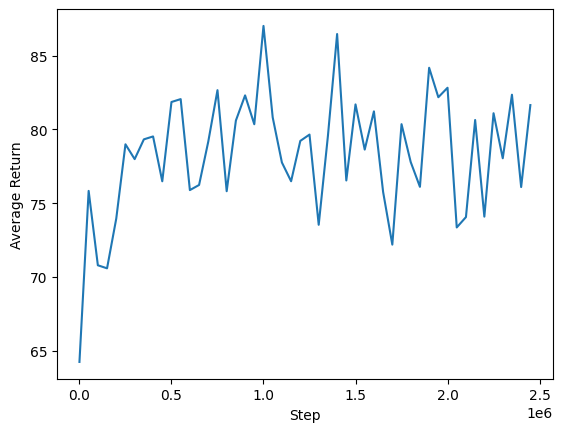

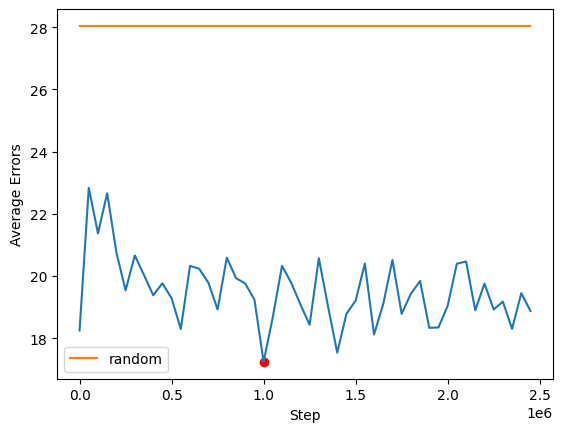

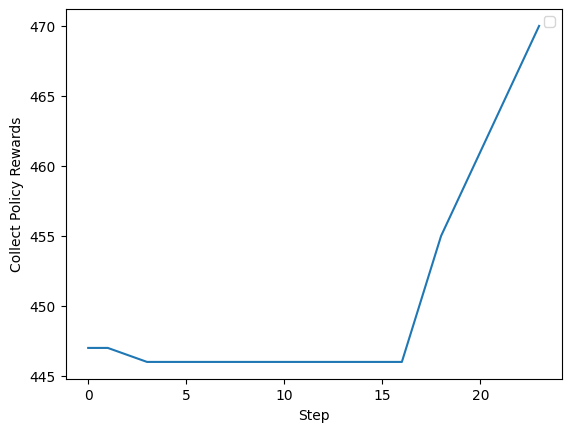

ValueError: setting an array element with a sequence.

In [ ]:
%matplotlib inline
steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, pred_errors)
plt.plot(steps, np.ones(len(pred_errors))*rand_pred_error, label = "random")
plt.scatter([steps[np.argmin(pred_errors)]], [np.min(pred_errors)], c = 'r')
plt.ylabel('Average Errors')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(collect_rewards, np.ones(40)*200/40, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

In [33]:
# Evaluate model again
avg_return, avg_error, all_errors  = compute_avg_return(eval_py_env, agent.policy, n_agents, 500, batched = True)
print(avg_return, avg_error)

23.903477623462678 16.107738348098767


In [34]:
# Restore best model
checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [35]:
# Evaluate model again
avg_return, avg_error, all_errors  = compute_avg_return(eval_py_env, agent.policy, n_agents, 500, batched = True)
print(avg_return, avg_error)

24.14305732782185 15.925028651033056


In [36]:
saved_policy = tf.saved_model.load(train_log_dir)
#saved_policy = tf.saved_model.load("./models/RL/2023-06-09--00:06:51")
avg_return, avg_error, all_errors = compute_avg_return(eval_py_env, saved_policy, n_agents, 500, batched = True)
print(avg_return, avg_error, np.median(all_errors))

24.134128669500353 15.894728001632291 14.488019676922907
